<a href="https://colab.research.google.com/github/brunocosouza/NLP/blob/main/Pretraining%20Bidirectional_Encoder_Representations_from_Transformers_(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT

BERT (Bidirectional Encoder Representations from Transformers) codifica o contexto de forma bidirecional para explorar de forma particular o sentido semantico de cada palavra de modo à vetorizar seu valor corretamente. Pro exemplo na frase " ele foi ao banco para sacar dinheiro" e " ele foi ao banco para sentar" a palavra "banco" depende de um conhecimento posterior para trazer seu real sentido semantico. 

BERT é considerado um task-agnostic model, ou seja, ela requer uma mudança minima de arquitetura para uma grande range de aplicações em tarefas de processamento de linguagem natural.


## Input Representation

No processamento de linguagem natural, algumas tarefas (por exemplo, análise de sentimento) aceitam um único texto como entrada, enquanto em algumas outras tarefas (por exemplo, inferência de linguagem natural), a entrada é um par de sequências de texto. A seqüência de entrada de BERT representa, sem ambigüidade, os dois tipos, texto único e pares de texto. No primeiro caso, a sequência de entrada de BERT é a concatenação do token de classificação especial “< cls >”, tokens de uma sequência de texto e o token de separação especial “< sep >” ("< cls > tokens_text < sep >"). No último, a sequência de entrada de BERT é a concatenação de “< cls >”, tokens da primeira sequência de texto, “< sep >”, tokens da segunda sequência de texto e “< sep >” ("< cls > token_text_a < sep > token_text_b < sep >").

In [1]:
!pip install -U d2l

     |████████████████████████████████| 81kB 5.9MB/s 


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b = None):
  tokens = ['<cls>'] + tokens_a + ['<sep>']
  segments = [0] * (len(tokens_a) + 2)
  if tokens_b is not None:
    tokens += tokens_b + ['<sep>']
    segments += [1] * (len(tokens_b) + 1)
  return tokens, segments

BERT escolheu o Transformer encoder como sua arquitetura bidirectional. Como no Transformer encoder,  embedding posicional (para identificar a posição da palavra na sentença) sao adicionados à cada posição da sentença de entrada no modelo BERT

In [4]:
class BERTEncoder(nn.Module):
  def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
               ffn_num_hiddens, num_heads, num_layers, dropout,
               max_len = 1000, key_size = 768, query_size = 768, value_size = 768,
               **kwargs):
    super(BERTEncoder, self).__init__(**kwargs)
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
    self.segment_embedding = nn.Embedding(2, num_hiddens)
    self.blks = nn.Sequential()
    for i in range(num_layers): #verificar Transformer Encoder
      self.blks.add_module(f"{i}", d2l.EncoderBlock(
          key_size, query_size, value_size, num_hiddens, norm_shape,
          ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
    self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

  def forward(self, tokens, segments, valid_lens):
    X = self.token_embedding(tokens) + self.segment_embedding(segments)
    X = X + self.pos_embedding.data[:, : X.shape[1], :]
    for blk in self.blks:
      X = blk(X, valid_lens)
    return X

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [6]:
encoder.blks

Sequential(
  (0): EncoderBlock(
    (attention): MultiHeadAttention(
      (attention): DotProductAttention(
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (W_q): Linear(in_features=768, out_features=768, bias=True)
      (W_k): Linear(in_features=768, out_features=768, bias=True)
      (W_v): Linear(in_features=768, out_features=768, bias=True)
      (W_o): Linear(in_features=768, out_features=768, bias=True)
    )
    (addnorm1): AddNorm(
      (dropout): Dropout(p=0.2, inplace=False)
      (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (ffn): PositionWiseFFN(
      (dense1): Linear(in_features=768, out_features=1024, bias=True)
      (relu): ReLU()
      (dense2): Linear(in_features=1024, out_features=768, bias=True)
    )
    (addnorm2): AddNorm(
      (dropout): Dropout(p=0.2, inplace=False)
      (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
  (1): EncoderBlock(
    (attention): MultiHeadAttention(
      (attention):

In [7]:
encoder.token_embedding, encoder.segment_embedding

(Embedding(10000, 768), Embedding(2, 768))

We define tokens to be 2 BERT input sequences of length 8, where each token is an index of the vocabulary. The forward inference of BERTEncoder with the input tokens returns the encoded result where each token is represented by a vector whose length is predefined by the hyperparameter num_hiddens. This hyperparameter is usually referred to as the hidden size (number of hidden units) of the Transformer encoder.

In [8]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape, tokens.shape

(torch.Size([2, 8, 768]), torch.Size([2, 8]))

In [9]:
tokens, segments

(tensor([[8591, 7297, 5999, 5332, 8144,   20, 2941, 2111],
         [6723, 1928, 7891, 9403, 8160, 8915, 4842, 9594]]),
 tensor([[0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 1, 1, 1, 1, 1]]))

In [10]:
encoded_X[:1,:1,:50]

tensor([[[ 1.1707, -0.7642,  1.2720,  0.0570,  0.3845,  0.2649,  0.2280,
           0.1486, -0.2950,  0.5735, -0.9621,  0.6385,  0.2041,  0.1260,
          -0.0210, -0.3706,  1.0208,  1.8274,  0.3330,  0.0445, -0.0989,
           1.0014,  0.4597, -1.1646,  1.0096,  0.3242, -0.1712,  1.5745,
           1.4495,  0.6762,  0.2021, -0.5267, -0.7261, -0.1820,  0.1174,
          -0.6665, -0.5496,  0.5325,  0.0782, -1.6603,  1.9442,  0.8129,
           1.7289,  0.7591, -0.0930, -1.7556,  0.8291, -0.2904, -0.2456,
          -0.0932]]], grad_fn=<SliceBackward>)

## Masked Language Modeling

Para codificar(encode) contexto de forma bidirecional representando cada token, BERT mascara os tokens de modo randomico, e usa esses tokens do contexto bidirecioanl para prever os tokens mascarados. Essa tarefa é referida como masked language model.

Se um token é mascarado para previsão ded dados, a entrada dos dados terão o formado de:



*   < mask > token para 80% do tempo ("this movie is great" -> "this movie is "< mask >" 
*   um token radomizado para 10% dos casos ("this movie is great" -> "this movie is drink")
*   nenhuma alteração para 10% dos casos ("this movie is great" -> "this movie is great")

Dessa forma o token especial < mask > não vai ocasionar erros ou vieses ao modelo na etapa de fine-tuning (treinamento melhorado ou destinado a certa tarefa especifica), pois o token em questão aparecera apenas na etapa de pretraining.

Observe que por 10% de 15% do tempo, um token aleatório é inserido. Este ruído ocasional encoraja o BERT a ser menos tendencioso para o token mascarado (especialmente quando o token de rótulo permanece inalterado).





In [11]:
class MaskLM(nn.Module):
  def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
    super(MaskLM, self).__init__(**kwargs)
    self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                             nn.ReLU(),
                             nn.LayerNorm(num_hiddens),
                             nn.Linear(num_hiddens, vocab_size))
    
  def forward(self, X, pred_positions):
    num_pred_positions = pred_positions.shape[1]
    pred_positions = pred_positions.reshape(-1)
    batch_size = X.shape[0]
    batch_idx = torch.arange(0, batch_size)
    batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
    masked_X = X[batch_idx, pred_positions]
    masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
    mlm_Y_hat = self.mlp(masked_X)
    return mlm_Y_hat

In [12]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

Considerando o valor real como mlm_Y, podemos calcular a perda da cross entropy do modelo BERT.

In [13]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 11, 12]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l

tensor([9.2648, 9.1790, 9.1043, 9.1087, 9.1818, 9.3099],
       grad_fn=<NllLossBackward>)

In [14]:
## Apenas para verificar como o modelo funciona no passo a passo
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
encoded_X.shape, mlm_positions.shape, mlm_positions.reshape(-1).shape
batch_idx = torch.arange(0, encoded_X.shape[0])
num_pred_positions = mlm_positions.shape[1]
batch_size = encoded_X.shape[0]
batch_idx = torch.arange(0, batch_size)
batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
batch_idx
masked_X = encoded_X[batch_idx, mlm_positions.reshape(-1)]
encoded_X.shape, masked_X.shape, batch_idx, mlm_positions.reshape(-1)
masked_X[1,:].shape == encoded_X[1,6,:].shape

True

## Next Sentence Prediction

Embora a modelagem de linguagem mascarada seja capaz de codificar contexto bidirecional para representar palavras, ela não modela explicitamente a relação lógica entre pares de texto. Para ajudar a entender a relação entre duas sequências de texto, o BERT considera uma tarefa de classificação binária, a previsão da próxima frase, em seu pré-treinamento. Ao gerar pares de frases para pré-treinamento, na metade do tempo eles são de fato frases consecutivas com o rótulo “Verdadeiro”; enquanto, na outra metade do tempo, a segunda frase é amostrada aleatoriamente do corpus com o rótulo “False”.

A seguinte classe NextSentencePred usa um MLP de uma camada oculta para prever se a segunda frase é a próxima frase da primeira na sequência de entrada de BERT. Devido à autoatenção no codificador do Transformer, a representação BERT do token especial “< cls >” codifica as duas sentenças da entrada. Portanto, a camada de saída (self.output) do classificador MLP assume X como a entrada, onde X é a saída da camada oculta MLP cuja entrada é o token codificado “< cls >”.


In [15]:
class NextSentencePred(nn.Module):
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [16]:
# PyTorch by default won't flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

## Colocando tudo junto

Quando treinando BERT, a perda final é uma combinação linear da função de perda para a masked language e a predição da proxima sentença. Portanto, podemos agora definir nossa classe BERTModel instanciando as três classes criadas BERTEncoder, MaskLM, and NextSentencePred. A etapa forward retorna a representação BERT codificada, predição do modelo masked language e a predição da tarefa next sentence (encoded_X, mlm_Y_hat, nsp_Y_hat).

In [17]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## The Dataset for Pretraining BERT

Para pretreinar nosso modelo BERT nos precisamos gerar um dataset no formato ideial para facilitar as duas tarefas de pretreinamento : masked language modelin e next sentence prediction. Por um lado o modelo original BERT é pretreinado usando a concatenação de 2 dataset BookCorpus e English Wikipedia. Por outro lado, o modelo BERT pretreinado para uso pode não ser aplicado corretamente em tarefas especificas como a medicina. Dessa forma, esta se tornando popular customizar datasets para pretreinar o modelo BERT. Para nosso caso usaremos um pequeno corpus WikiText-2.

WikiText-2 retém as pontuações originais, facilitando a tarefa de next sentence prediction e retém, também, numeros e case originais.

In [18]:
import os
import random

In [19]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
  file_name = os.path.join(data_dir, 'wiki.train.tokens')
  with open(file_name, 'r') as f:
    lines = f.readlines()
  paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.split(' . ')) >= 2]
  random.shuffle(paragraphs)
  return paragraphs

In [20]:
d2l.DATA_HUB['wikitext-2']

('https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip',
 '3c914d17d80b1459be871a5039ac23e752a53cbe')

### Next Sentence Prediction Task

In [21]:
# _get_next_sentence function generates a training example for the binary classification task.
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

A função anterior gera exemplos de treinamento para a next sentence predicition da entrada *paragraph* invocando a função **_get_next_sentence()**.
Aqui *paragraph* é uma lista de sentenças, onde cada sentença é uma lista de tokens. O argumento *max_len* especifica o tamanho maximo da senquencia de entrada BERT durante o pretreinamento.

In [22]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
  nsp_data_from_paragraph = []
  for i in range(len(paragraph) - 1):
    tokens_a, tokens_b, is_next = _get_next_sentence(
        paragraph[i], paragraph[i + 1], paragraphs
    )
    # Consider 1 '<cls>' token and 2 '<sep>' tokens
    if len(tokens_a) + len(tokens_b) + 3 > max_len:
      continue
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    nsp_data_from_paragraph.append((tokens, segments, is_next))
  return nsp_data_from_paragraph

### Generating the Masked Language Modeling Task

Para gerar exemplos de treinamento para a tarefa de modelagem de linguagem mascarada a partir de uma sequência de entrada de BERT, definimos a seguinte função _replace_mlm_tokens. Em suas entradas, tokens é uma lista de tokens que representam uma sequência de entrada de BERT, candidate_pred_positions é uma lista de índices de token da sequência de entrada de BERT excluindo aqueles de tokens especiais (tokens especiais não são previstos na tarefa de modelagem de linguagem mascarada) e num_mlm_preds indica o número de previsões (recorde 15% de tokens aleatórios para prever). Em cada posição de previsão, a entrada pode ser substituída por um token especial “< mask >” ou um token aleatório, ou permanecer inalterado. No final, a função retorna os tokens de entrada após uma possível substituição, os índices de token onde as previsões ocorrem e os rótulos para essas previsões.

In [23]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # Make a new copy of tokens for the input of a masked language model,
    # where the input may contain replaced '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [24]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

### Transforming Text into the Pretraining Dataset

Agora estamos quase prontos para customizar uma classe Dataset para pré-treinamento de BERT. Antes disso, ainda precisamos definir uma função auxiliar _pad_bert_inputs para anexar os tokens especiais “< mask >” às entradas. Seus argumentos *example* contêm as saídas das funções auxiliares _get_nsp_data_from_paragraph e _get_mlm_data_from_tokens para as duas tarefas de pré-treinamento.

In [25]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

Colocando as funções auxiliares para gerar exemplos de treinamento das duas tarefas de pré-treinamento, e a função auxiliar para preencher entradas juntas, personalizamos a seguinte classe _WikiTextDataset como o conjunto de dados WikiText-2 para pré-treinamento de BERT. Ao implementar a função $__getitem__$, podemos acessar arbitrariamente os exemplos de pré-treinamento (modelagem de linguagem mascarada e previsão da próxima frase) gerados a partir de um par de frases do corpus WikiText-2.

In [26]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [27]:
def load_data_wiki(batch_size, max_len):
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [28]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [29]:
len(vocab)

20256

In [30]:
train_iter.dataset[1]

(tensor([    3,     9,  3340,     6,     5,  8636,   586,     2,     6,  9717,
             7,     5,  8636, 17973,     8,    62,   370,   586,     2,   302,
            44,   379,     2,    10,  1755,  1828,     4,   618,    19,     2,
             2,   170,   640,  1005,    13,  2365,    89,    22,  3643,   623,
             6,     2,     2,    48,   214,     0,   170,    10,  1098,     5,
          2421,     4,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(52.),
 tensor([ 7, 18, 22, 29, 30, 41, 42, 45,  0,  0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([3573,    6, 2182,  214,  329,   57, 1679,  522,    0,    0]),
 tensor(0))

## Pretraining BERT

Para começar, carregamos o conjunto de dados WikiText-2 como minibatches de exemplos de pré-treinamento para modelagem de linguagem mascarada e previsão da próxima frase. O tamanho do lote é 512 e o comprimento máximo de uma sequência de entrada de BERT é 64. Observe que no modelo BERT original, o comprimento máximo é 512.

O BERT original tem duas versões de tamanhos de modelo diferentes. O modelo básico (BERTBASE) usa 12 camadas (blocos codificadores do Transformer) com 768 unidades ocultas (tamanho oculto) e 12 cabeças de autoatenção. O modelo grande (BERTLARGE) usa 24 camadas com 1024 unidades ocultas e 16 cabeças de autoatenção. Notavelmente, o primeiro tem 110 milhões de parâmetros, enquanto o último tem 340 milhões de parâmetros. Para demonstração com facilidade, definimos um pequeno BERT, usando 2 camadas, 128 unidades ocultas e 2 cabeças de autoatenção.

In [31]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [32]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()


Antes de definir o loop de treinamento, definimos uma função auxiliar _get_batch_loss_bert. Dado o fragmento de exemplos de treinamento, esta função calcula a perda para a modelagem de linguagem mascarada e as tarefas de previsão da próxima frase. Observe que a perda final do pré-treinamento de BERT é apenas a soma da perda de modelagem da linguagem mascarada e da perda de previsão da próxima frase.

In [33]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass (return encoded_X, mlm_Y_hat, nsp_Y_hat)
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [34]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  trainer = torch.optim.Adam(net.parameters(), lr = 1e-3)
  step, timer = 0, d2l.Timer()
  animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
  # Sum of masked language modeling losses, sum of next sentence prediction
  # losses, no. of sentence pairs, count
  metric = d2l.Accumulator(4)
  num_steps_reached = False
  while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
      tokens_X = tokens_X.to(devices[0])
      segments_X = segments_X.to(devices[0])
      valid_lens_x = valid_lens_x.to(devices[0])
      pred_positions_X = pred_positions_X.to(devices[0])
      mlm_weights_X = mlm_weights_X.to(devices[0])
      mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
      trainer.zero_grad()
      timer.start()
      mlm_l, nsp_l, l = _get_batch_loss_bert(
          net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
          pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
      l.backward()
      trainer.step()
      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
      timer.stop()
      animator.add(step + 1,
                   (metric[0] / metric[3], metric[1] / metric[3]))
      step += 1
      if step == num_steps:
        num_steps_reached = True
        break
      
  print(f'MLM loss {metric[0] / metric[3]:.3f}, '
        f'NSP loss {metric[1] / metric[3]:.3f}')
  print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
        f'{str(devices)}')


MLM loss 6.090, NSP loss 0.696
5515.3 sentence pairs/sec on [device(type='cuda', index=0)]


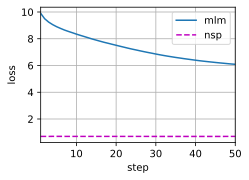

In [35]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### Representing Text with BERT

Apos pretreinar BERT, podemos usar pretraining BERT para representar um texto único, um par de texto ou qualquer token neles. A função a seguir retorna a representação do modelo BERT para todos os tokens no *tokens_a* e *tokens_b*

In [36]:
def get_bert_encoding(net, tokens_a, tokens_b = None):
  tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
  token_ids = torch.tensor(vocab[tokens], device = devices[0]).unsqueeze(0)
  segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
  valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
  encoded_X, _, _ = net(token_ids, segments, valid_len)
  return encoded_X

Depois de inserir tokens especiais “< cls >” (usados para classificação) e “< sep >” (usados para separação), a sequência de entrada de BERT tem um comprimento de seis. Como zero é o índice do token “< cls >”, encoded_text [:, 0,:] é a representação BERT de toda a frase de entrada. Para avaliar o token polissêmico “crane”, também imprimimos os três primeiros elementos da representação BERT do token.

In [37]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls[0][:3], encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 tensor([-0.5877, -0.9931,  1.5063], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([-0.3299, -1.7970,  1.4374], device='cuda:0', grad_fn=<SliceBackward>))

Agora vamos considerar um par de sentenças " a crane driver came" e "he just left". Note que para os 3 primeiros elementos, a palavra "crane" mudou seu valor, isso ocorreu porque a palavra foi inserida em um contexto diferente ( o significado dela esta diferente como por exemplo na palavra banco "banco para tirar dinheiro e banco para sentar"). Enquanto que o token especial de classificação representa o mesmo valor vetorizado

In [38]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_text_cls[0][:3], encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 tensor([-0.5877, -0.9931,  1.5063], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([-0.2478, -2.2473,  2.0437], device='cuda:0', grad_fn=<SliceBackward>))